In [83]:
#This is the code for building a time series prediction model using the Prophet library.
import pandas as pd 
#The original name was fbprophet
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
import warnings
warnings.filterwarnings("ignore")

In [84]:
#train_test_split
def train_test_split(df_inner,test_size=0.2):
    """
    Split the data into training and testing sets. default test_size=0.2
    """
    train_size = int(len(df_inner)*(1-test_size))
    train_set = df_inner.iloc[:train_size]
    test_set = df_inner.iloc[train_size:]
    return train_set,test_set

In [85]:
def calculate_RMSE(df:pd.DataFrame)->float:
    """
    Calculate the root mean square error of the model
    """
    return ((df['y']-df['yhat'])**2).mean()**0.5

In [86]:
# use the 'make_predictions_df' function to make predictions on our forecasted data
def include_all_data(forecast, train,test):
    """
    Include all the data in the prediction dataframe,which includes the true price, 
    the predicted price, and the confidence interval.
    "y" is the true price, "yhat" is the predicted price, "yhat_lower" is the lower bound of the confidence interval, and "yhat_upper" is the upper bound of the confidence interval.
    """
    all=pd.concat([train,test])
    # create a dataframe to store the predictions
    prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    # merge the predictions with all the data
    prediction['y']=all['y']
    return prediction

In [87]:
def visualization(df:pd.DataFrame,path=None,figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.plot(df['ds'],df['y'],label='True Price',color='r')
    plt.plot(df['ds'],df['yhat'],label='Predicted Price',color='b')
    plt.fill_between(df['ds'],df['yhat_lower'],df['yhat_upper'],color='k',alpha=0.2)
    plt.title(f' Price Prediction')
    # add a vertical dashed line to mark the separation point between training and testing data
    plt.axvline(test.iloc[0,0], color='k', ls='--', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    if path is not None:
        plt.savefig(path)

In [88]:
def create_joint_plot(forecast,x='yhat', y='y', path=None,title=None):
    
    
    # create a joint plot with 'yhat' as the x-axis and 'y' as the y-axis
    g = sns.jointplot(x='yhat', y='y', data=forecast, kind="reg", color="b")
    
    
    #To plot the image with a fair scale, the range of the x-axis appearing on the image and the range of the y-axis should be the same. To ensure no points are missed, I need to find the minimum and maximum values and set them as the range for the image.
    total_max=max(forecast["y"].max(),forecast["yhat"].max())
    total_min=min(forecast["y"].min(),forecast["yhat"].min())
    g.ax_joint.set_xlim(total_min, total_max)
    g.ax_joint.set_ylim(total_min, total_max)
    
    
    #set the width and height of the figure
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    
    # access the second subplot in the figure (scatter plot) and set its title if provided
    ax = g.fig.axes[1]
    if title is not None:
        ax.set_title(title, fontsize=16)

    # access the first subplot in the figure (histograms) and display the correlation coefficient
    ax = g.fig.axes[0]
    fig_center= (total_max+total_min)/2  # the center location of the figure
    ax.text(fig_center,fig_center,"R = {:+4.2f}".format(forecast.loc[:,['y','yhat']].corr().iloc[0,1]), fontsize=16)

    #set labels, limits, and grid lines for the x and y axes
    ax.set_xlabel('Predictions', fontsize=15)
    ax.set_ylabel('Observations', fontsize=15)

    ax.grid(ls=':')
    if path is not None:
        g.savefig(path)
    # set the font size for the x-axis and y-axis tick labels
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    
    # add gridlines
    ax.grid(ls=':')

In [93]:
#load data
df = pd.read_csv('data/ALL_cleaned.csv',parse_dates=['DATE'])

In [94]:
#we use logPrice rather than Close because it is more linear, and we can convert it back to price later
#create a prophet model
m = Prophet(seasonality_mode='multiplicative',
            growth='linear',
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True)
#because the minimum interval of time is 1 day, so we don't need to set the daily_seasonality


In [95]:
#fit the format of prophet model; the column names should be 'ds' and 'y'
df_with_logPrice_DATA = df[["DATE","logPrice"]]
df_with_logPrice_DATA.columns= ["ds","y"]
train,test=train_test_split(df_with_logPrice_DATA)

In [96]:
m.fit(train)

12:44:04 - cmdstanpy - INFO - Chain [1] start processing
12:44:06 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
df_cv = cross_validation(m, initial='1095 days', period='15 days', horizon = '30 days')
#1095 days~3 years

  0%|          | 0/23 [00:00<?, ?it/s]12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 1/23 [00:01<00:42,  1.93s/it]12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing
  9%|▊         | 2/23 [00:04<00:44,  2.14s/it]12:44:18 - cmdstanpy - INFO - Chain [1] start processing
12:44:19 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 3/23 [00:05<00:39,  1.97s/it]12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 4/23 [00:07<00:34,  1.83s/it]12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:23 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 5/23 [00:09<00:34,  1.89s/it]12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:25 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 6/23 [00:11<00:32,  1.92s/it]12:44:25

In [99]:
df_p = performance_metrics(df_cv,rolling_window=1)
print("performance metrics of single datasource model:\n",df_p,'\n')

performance metrics of single datasource model:
   horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.010121  0.100603  0.081976  0.017592  0.014678  0.017593   

   coverage  
0  0.263768   


In [100]:
#an dataframe with only one column ds, which is the date we want to predict.
#include_history=False means we don't need to predict the history data.the default value is True
prediction = m.make_future_dataframe(periods=366,freq='1D',include_history=True)

In [101]:
forecast = m.predict(prediction)
# display the forecasted results

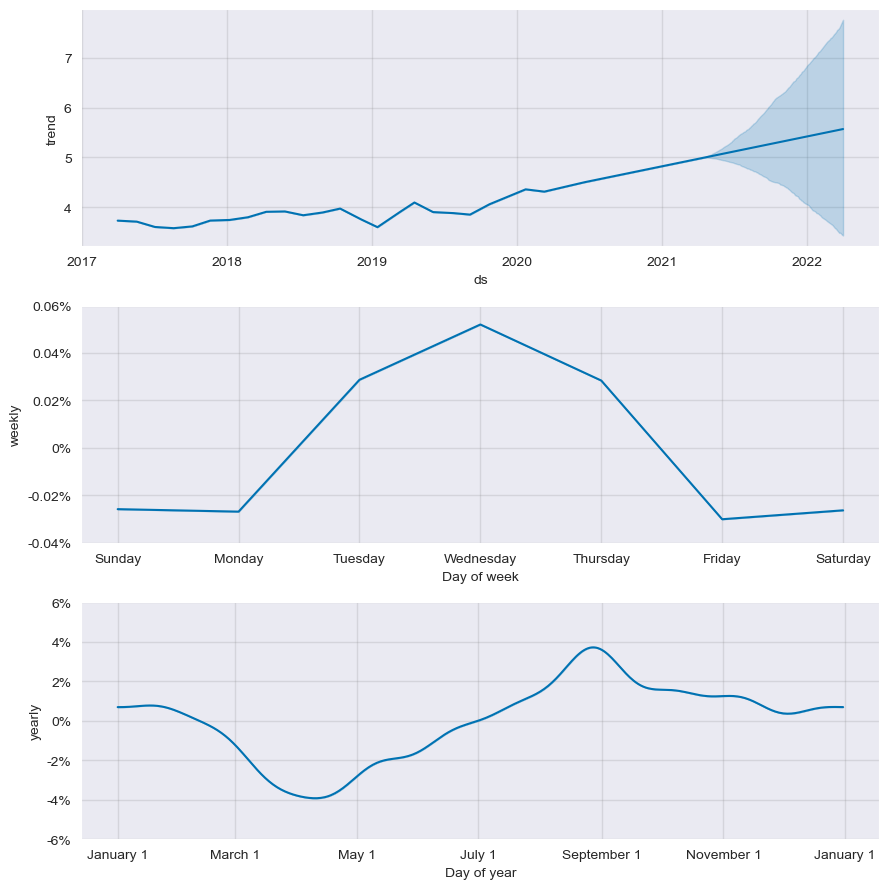

In [102]:
fig=m.plot_components(forecast)
fig.savefig("./pictures/single_source_data_prediction_decomposition")

In [103]:
result = include_all_data(forecast, train, test)
print("single datasource prediction\n",result.head(5),'\n')

single datasource prediction
           ds      yhat  yhat_lower  yhat_upper         y
0 2017-04-01  3.583794    3.544612    3.623805  3.581433
1 2017-04-02  3.582512    3.543651    3.623499  3.581433
2 2017-04-03  3.581264    3.540184    3.621109  3.581433
3 2017-04-04  3.582215    3.539135    3.623687  3.588852
4 2017-04-05  3.582057    3.541137    3.622422  3.583658 


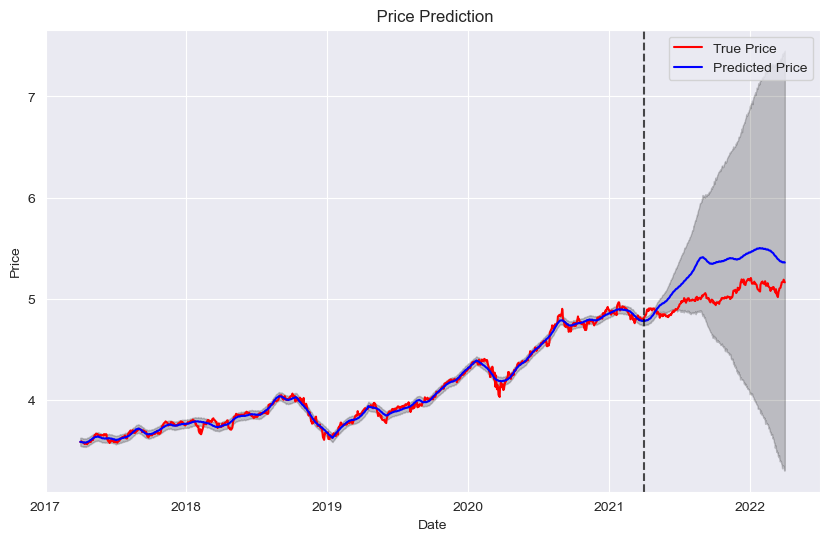

In [104]:
visualization(result,path="./pictures/single_source_data_prediction.png")

In [106]:
result_predict= result[result['ds'] >=test.iloc[0,0]]
#RMSE for one month
single_source_RMSE=calculate_RMSE(result_predict.iloc[0:30,:])
print(f"RMSE for one month: {single_source_RMSE}")

RMSE for one month: 0.07327385224841693


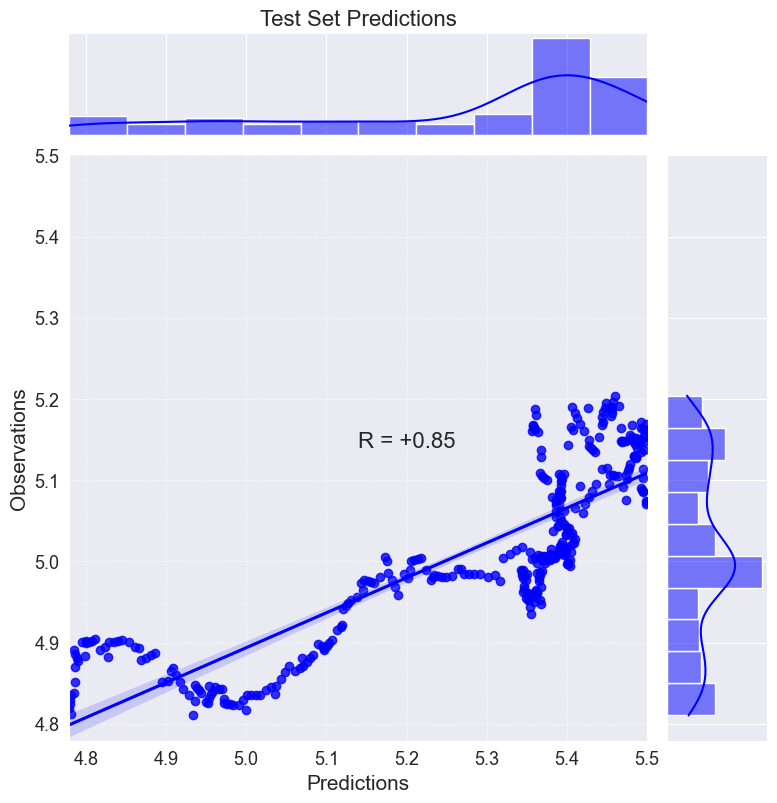

In [107]:
#the prediction is higher than the true price, which means the model is not good enough.

create_joint_plot(result_predict,title='Test Set Predictions',path="./pictures/single_source_data_Test_set_predictions.png")
#这个要保证x与y是一个方块

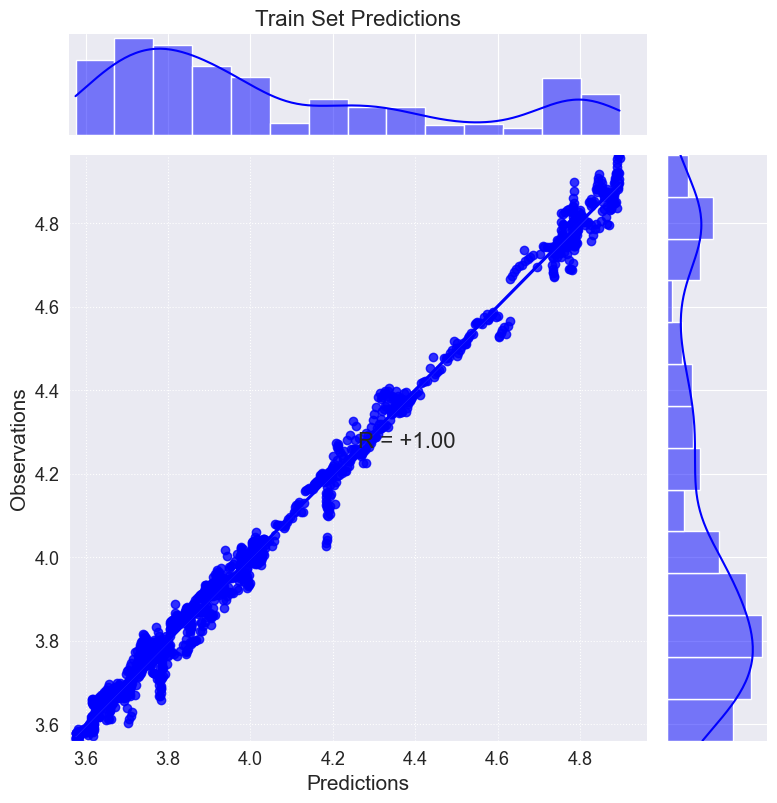

In [108]:
create_joint_plot(result[result['ds'] <test.iloc[0,0]],title='Train Set Predictions',path="./pictures/single_source_data_Train_set_predictions.png")
#不对，这里把test set的结果也加上了。
#very very good

In [109]:
#use multiple sauce data to predict

In [110]:
#create a new model
m2=Prophet( seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)

In [111]:
#add 2 data sources,mode=multiplicative
m2.add_regressor('T10Y2Y', mode='multiplicative')
m2.add_regressor('DFF', mode='multiplicative')

In [68]:
df2=df.drop("Close",axis=1)
df2.rename(columns={"DATE":"ds","logPrice":"y"},inplace=True)
df2.head()

,ds,DFF,T10Y2Y,y
0,2017-04-01,0.82,1.11,3.581433
1,2017-04-02,0.82,1.11,3.581433
2,2017-04-03,0.91,1.11,3.581433
3,2017-04-04,0.91,1.11,3.588852
4,2017-04-05,0.91,1.10,3.583658


In [69]:
train2,test2=train_test_split(df2)

In [70]:
m2.fit(train2)


23:16:38 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
#cross validation
df_cv2 = cross_validation(m2, initial='1095 days', period='15 days', horizon = '30 days')
#1095 days~3 years


  0%|          | 0/23 [00:00<?, ?it/s]23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:40 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 1/23 [00:01<00:22,  1.00s/it]23:16:40 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] done processing
  9%|▊         | 2/23 [00:01<00:19,  1.06it/s]23:16:41 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 3/23 [00:02<00:16,  1.19it/s]23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 4/23 [00:03<00:15,  1.23it/s]23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:43 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 5/23 [00:04<00:14,  1.25it/s]23:16:43 - cmdstanpy - INFO - Chain [1] start processing
23:16:44 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 6/23 [00:05<00:14,  1.17it/s]23:16:44

In [72]:
df_p2 = performance_metrics(df_cv,rolling_window=1)
df_p2.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.010121,0.100603,0.081976,0.017592,0.014678,0.017593,0.262319


In [73]:
future2=m2.make_future_dataframe(periods=len(test2), freq='1D')

In [74]:
future2=pd.concat([future2,df2[["DFF","T10Y2Y"]]],axis=1)

In [75]:
future2

,ds,DFF,T10Y2Y
0,2017-04-01,0.82,1.11
1,2017-04-02,0.82,1.11
2,2017-04-03,0.91,1.11
3,2017-04-04,0.91,1.11
4,2017-04-05,0.91,1.10
...,...,...,...
1822,2022-03-28,0.33,0.11
1823,2022-03-29,0.33,0.06
1824,2022-03-30,0.33,0.04
1825,2022-03-31,0.33,0.04


In [76]:
result2=m2.predict(future2)

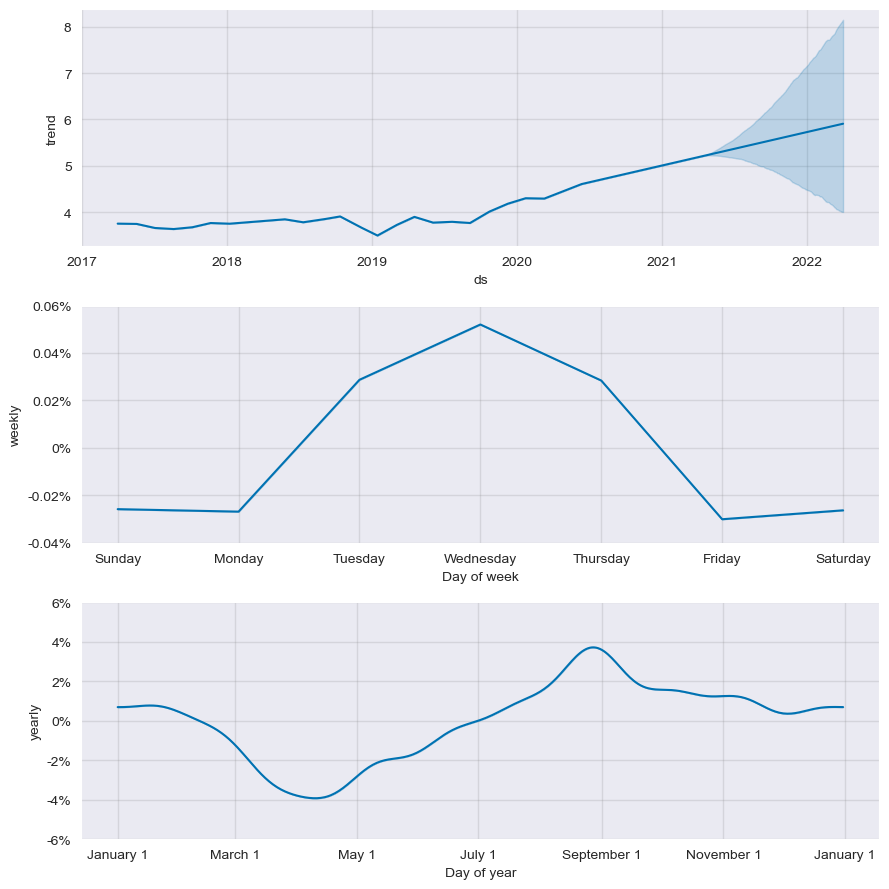

In [77]:
fig2=m.plot_components(result2)
fig2.savefig("./pictures/multiple_source_data_prediction_decomposition.png")

In [78]:
all_data2=include_all_data(result2,train2,test2)

In [79]:
all_data2.tail()

,ds,yhat,yhat_lower,yhat_upper,y
1822,2022-03-28,5.706541,3.876128,7.827803,5.168209
1823,2022-03-29,5.717530,3.879853,7.849362,5.187162
1824,2022-03-30,5.723054,3.875395,7.881460,5.180491
1825,2022-03-31,5.722270,3.870223,7.883329,5.162555
1826,2022-04-01,5.733135,3.867258,7.891253,5.160835


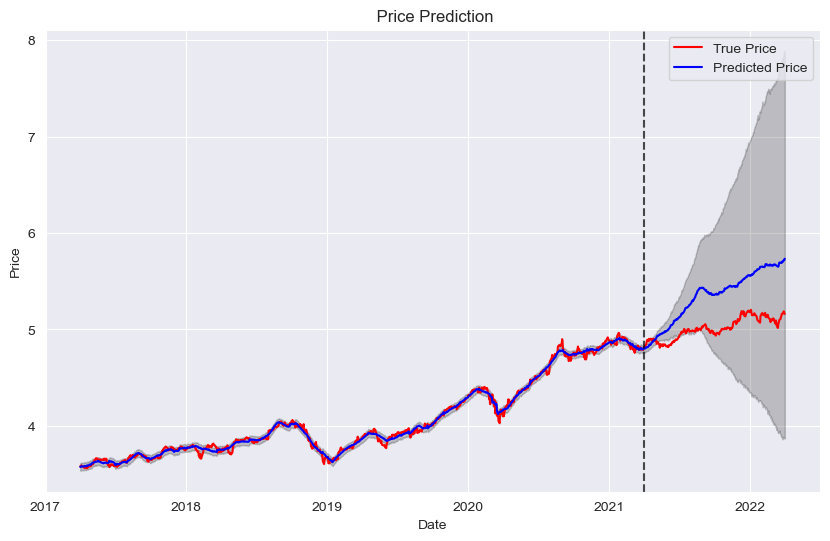

In [80]:
visualization(all_data2,path="./pictures/multiple_source_data_prediction.png")

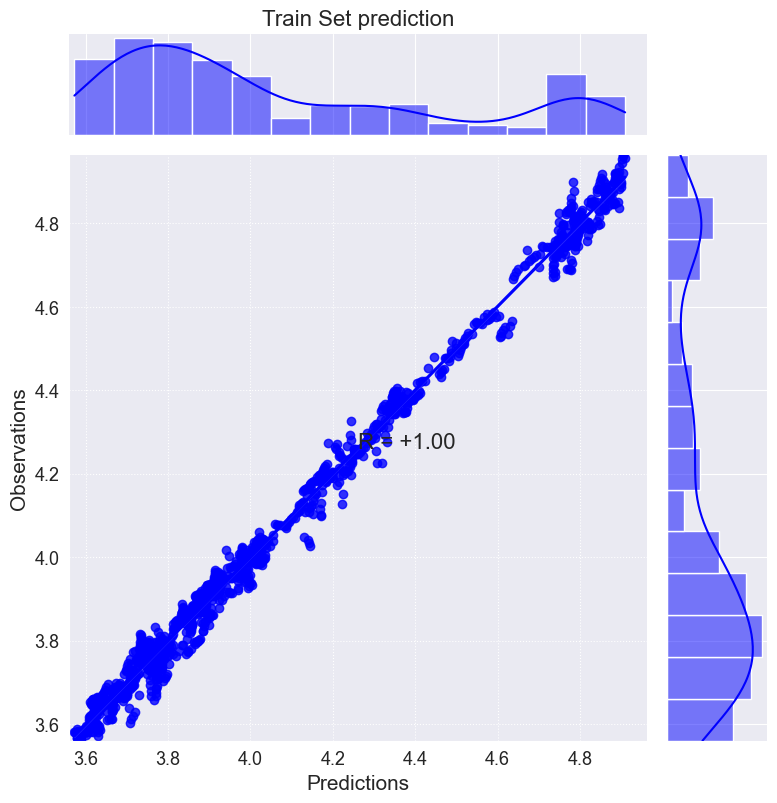

In [81]:
create_joint_plot(all_data2[all_data2['ds'] <test2.iloc[0,0]],title='Train Set prediction',path="./pictures/multiple_source_data_Train_set_predictions.png")

RMSE for one month: 0.043665378895017995


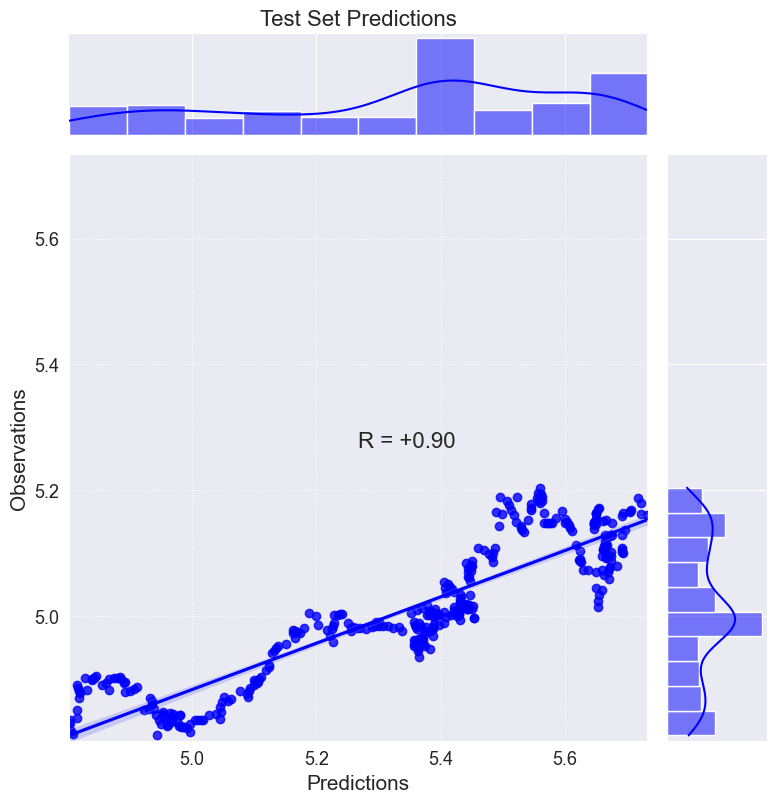

In [82]:
#prediction part
prediction2=all_data2[all_data2['ds'] >=test2.iloc[0,0]]
create_joint_plot(prediction2,title='Test Set Predictions',path="./pictures/multiple_source_data_Test_set_predictions.png")
mutiple_source_RMSE=calculate_RMSE(prediction2.iloc[0:30,:])
print(f"RMSE for one month: {mutiple_source_RMSE}")